# Feedback effects in neural systems (limiting the maximum values of current and voltage)

### The idea here is to verify the effects of positive or negative feedback in a neural network made out of spiking neurons.

One interesting thing here is the definition of "positive" or "negative" feedback in such a system.

## I'm adding a lower bond to the membrane and synapse values because I can't imagine something that has no absolute maximum value. In order to make it symmetrical to the positive values, the lower bond is the negative version of the threshold.

In [49]:
import numpy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 20, 12

### The neuron model parametres are the same as the ones used in Maass 2002.

As a simplification, the neurons have only one synapse that works as excitatory or inhibitory according to the sign of the weight (or, in the case of the feedback signal, the sign of the spike).

In [2]:
total_steps = 1000
vthres=15E-3
vreset=13.5E-3
ithres=1E-3 #I don't have data for this, but most of the times the currents are around nA and 1mA could probably fry a neuron.
step=1E-3
capm=30E-9
taum=30E-3
taue=3E-3

b=8
n=2**b
sa_ns = n/2 #total number of spikes in the input

#
# Starting values (to be used with all the simulations)
#
# sa_start = numpy.random.randint(0,2,n)
sa_start = numpy.zeros(n)
sa_start[:n/3]=1
numpy.random.shuffle(sa_start)

er_start = numpy.zeros(n)
oa_start = numpy.ones(n)
mv_start = 13E-3+numpy.random.rand(n)*(15.5-13)*1E-3


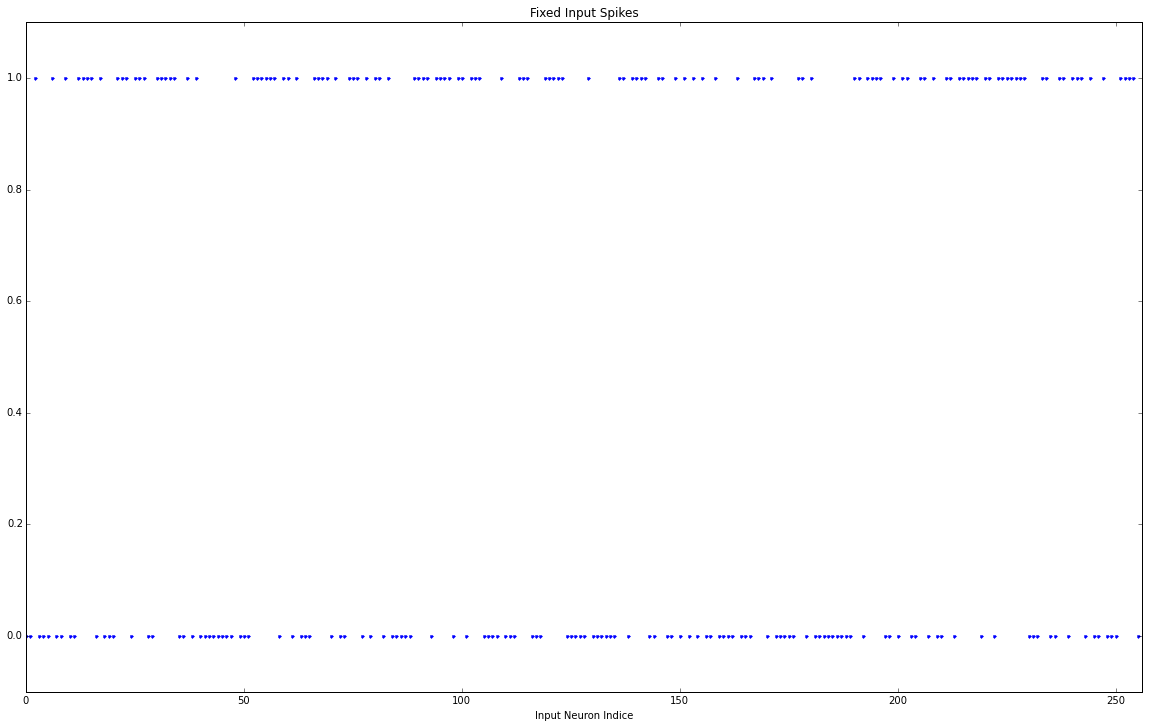

In [3]:
plt.plot(sa_start,'.');
plt.xlim(0,n);
plt.ylim(-0.1,1+0.1);
plt.title("Fixed Input Spikes");
plt.xlabel("Input Neuron Indice");

In [4]:
def simulate(feedback_func, wa, K=1):
    outputs_s=[]
    outputs_v=[]
    outputs_i=[]

    sa=numpy.array(sa_start)
    er=numpy.array(er_start)
    oa=numpy.array(oa_start)
    mv=numpy.array(mv_start)

    for s in xrange(total_steps):
        oa.fill(0)
        p_vthreshold_test = (mv>=vthres)
        n_vthreshold_test = (mv<-vthres)
        p_ithreshold_test = (er>ithres)
        n_ithreshold_test = (er<-ithres)                
        oa[p_vthreshold_test]=1 #sets the spikes
        outputs_s.append(oa.tolist()) #saves the spikes to a list
        outputs_v.append(mv.tolist()) #saves the membrane voltage to a list
        outputs_i.append(er.tolist()) #saves the membrane voltage to a list

        mv[p_vthreshold_test]=vreset
        mv[n_vthreshold_test]=-vthres #this new threshold is useful to keep the membrane in a physical plausible state

        er[p_ithreshold_test]=ithres
        er[n_ithreshold_test]=-ithres #this new threshold is useful to keep the synapse in a physical plausible state        

        er[:]+=oa.dot(wa) #internal spikes - ALL-TO-ALL

#         er[:]+=K*(sa+oa)*1E-9 #positive feedback
#         er[:]+=K*(sa-oa)*1E-9 #negative feedback
#         er[:]+=K*sa*1E-9 #receiving only the inputs
        er[:]+=feedback_func(K,sa,oa)*1E-9

        sa.fill(0) #Only the first spike train is sent to the network
        
        er[:]+=(-er/taue)*step
        mv[:]+=((-mv)/taum+er/capm)*step
    return outputs_s,outputs_v,outputs_i

# Here in this work, when we talk about feedback we mean:
- Positive: the output spikes are added (excitatory) to the input spikes: $K (sa-oa)$
- Negative: the output spikes are subtracted (inhibitory) of the input spikes: $K (sa+oa)$
- No Feedback: the output spikes are ignored: $K (sa)$

Where:  
$sa$ - input spikes  
$oa$ - output spikes  
$K$ - gain

In [5]:
nfb=lambda K,sa,oa: K*(sa-oa)
pfb=lambda K,sa,oa: K*(sa+oa)
nofb=lambda K,sa,oa: K*sa

# ALL-TO-ALL WITH GAUSSIAN RANDOM WEIGHTS

## Mean value (loc):0
## Standard deviation (scale):10nA

In [6]:
wa2a=numpy.random.normal(loc=0,scale=10,size=(n,n))*1E-9

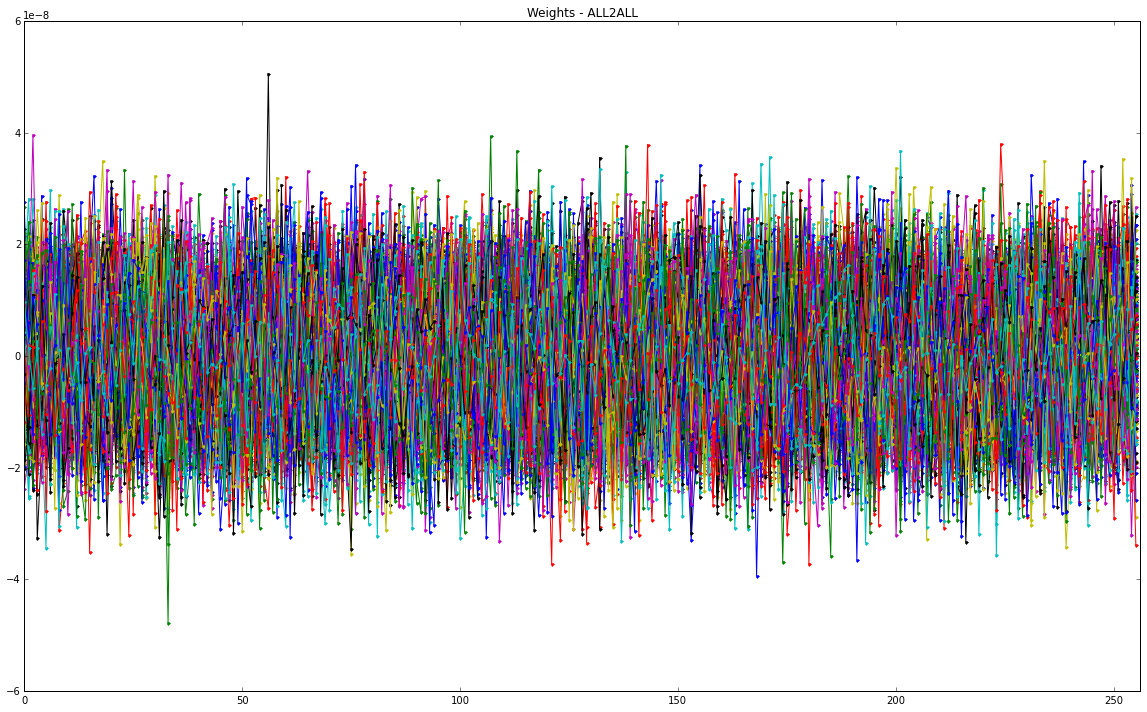

In [7]:
plt.plot(wa2a,'.-');
plt.xlim(0,len(wa2a));
plt.title("Weights - ALL2ALL");

In [8]:
wa2a.max(),wa2a.min(),wa2a.mean()

(5.058201114849006e-08, -4.7781096906046057e-08, 7.3428199038864421e-11)

## NEGATIVE FEEDBACK

In [9]:
nfb_outputs_s,nfb_outputs_v,nfb_outputs_i = simulate(nfb, wa2a)
print "Total Number of Spikes: %d" % numpy.array(nfb_outputs_s).sum()

Total Number of Spikes: 91899


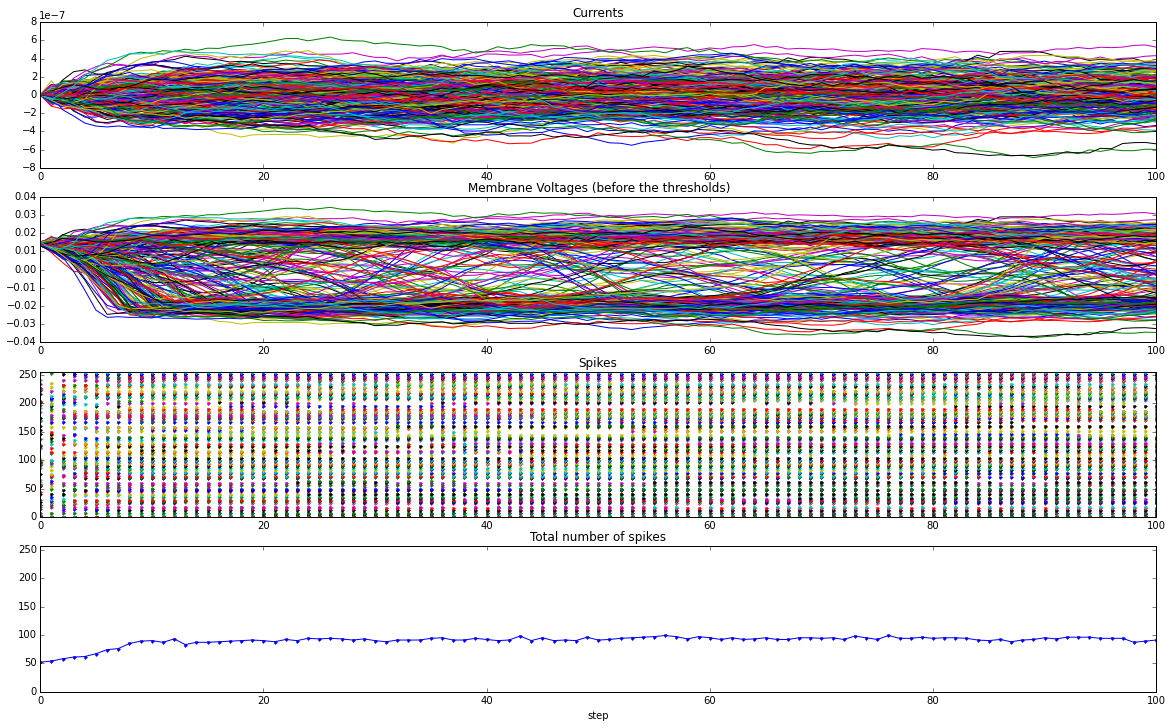

In [10]:
maxt=100

plt.subplot(411)
plt.plot(nfb_outputs_i);
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(nfb_outputs_v);
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(nfb_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(nfb_outputs_s),axis=1),'.-');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");


## POSITIVE FEEDBACK

In [11]:
pfb_outputs_s,pfb_outputs_v,pfb_outputs_i = simulate(pfb, wa2a)
print "Total Number of Spikes: %d" % numpy.array(pfb_outputs_s).sum()

Total Number of Spikes: 92847


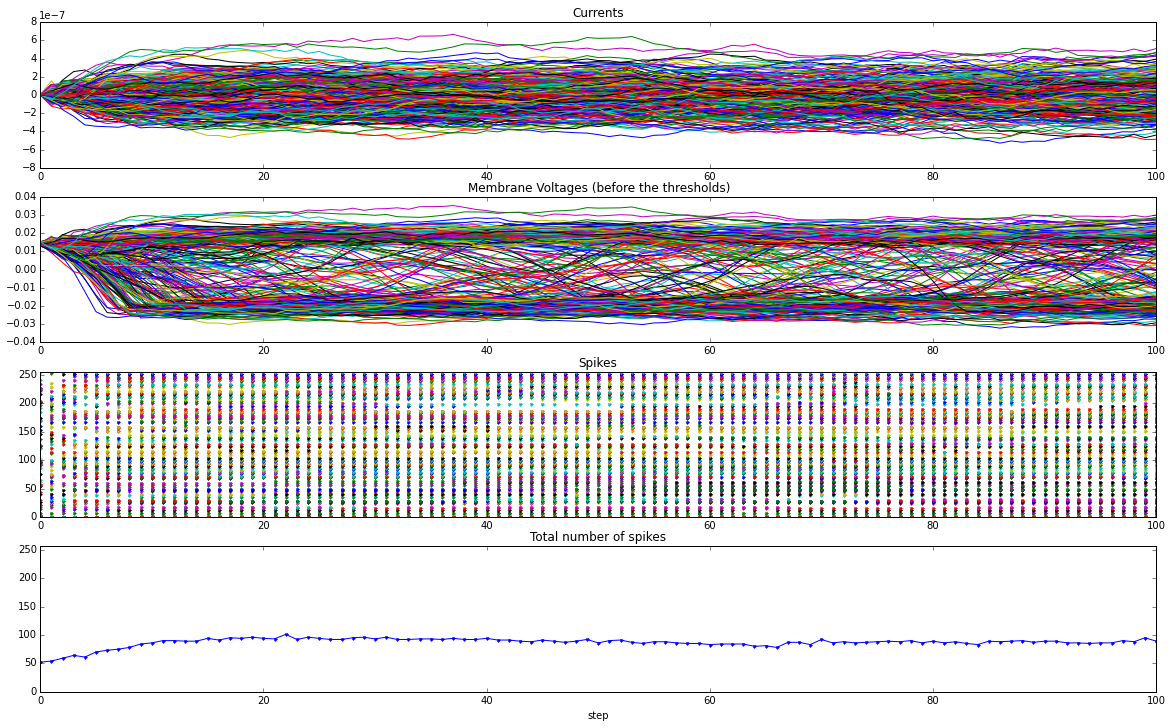

In [12]:
maxt=100

plt.subplot(411)
plt.plot(pfb_outputs_i);
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(pfb_outputs_v);
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(pfb_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(pfb_outputs_s),axis=1),'.-');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");

## NO FEEDBACK, ONLY THE INPUT

In [13]:
nofb_outputs_s,nofb_outputs_v,nofb_outputs_i = simulate(nofb, wa2a)
print "Total Number of Spikes: %d" % numpy.array(nofb_outputs_s).sum()

Total Number of Spikes: 93183


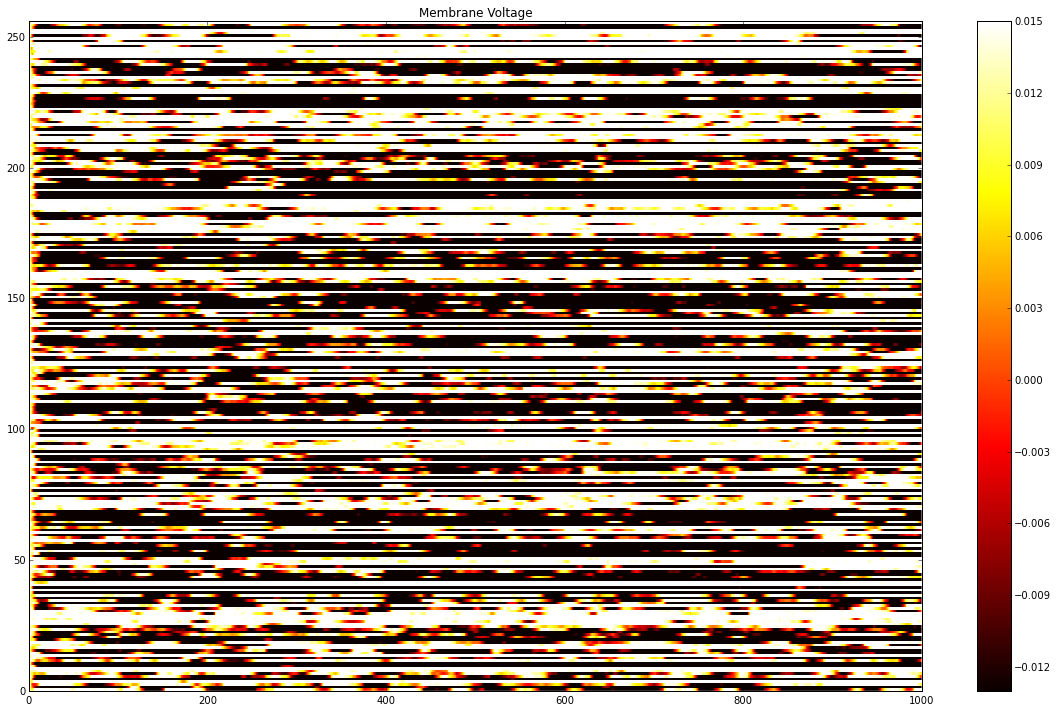

In [55]:
plt.imshow((numpy.array(nofb_outputs_v)).T, interpolation='none', origin='lower', aspect='auto',extent=[0,total_steps*step*1E3,0,n],cmap=cm.hot,vmin=-13E-3,vmax=15.0E-3);
plt.title("Membrane Voltage");
plt.colorbar();


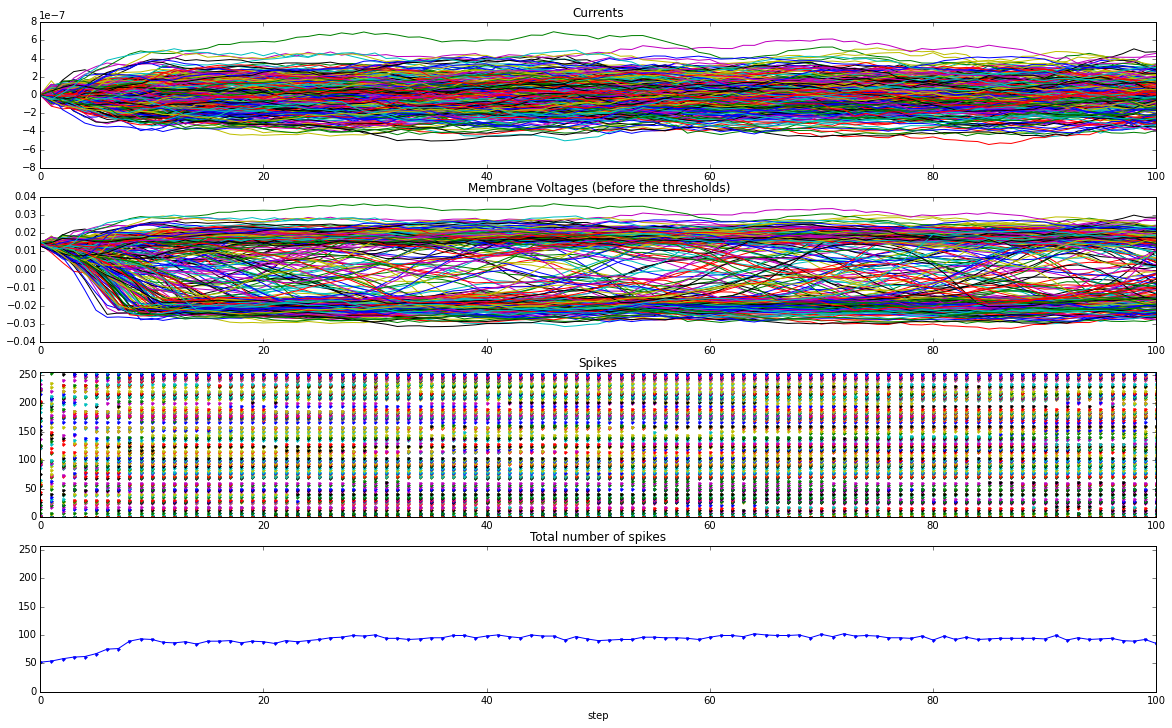

In [14]:
maxt=100

plt.subplot(411)
plt.plot(nofb_outputs_i);
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(nofb_outputs_v);
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(nofb_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(nofb_outputs_s),axis=1),'.-');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");

# Now I want to check the effects of the weights' mean value. 

## Mean value (loc): 0 to 1nA
## Standard deviation (scale):10nA
## NEGATIVE, POSITIVE AND NO FEEDBACK

In [15]:
meanvalues=numpy.linspace(0,1,100)

In [16]:
total_spikes_nfb_g=[numpy.array(simulate(nfb,numpy.random.normal(loc=i,scale=10,size=(n,n))*1E-9)[0]).sum() for i in meanvalues]
total_spikes_pfb_g=[numpy.array(simulate(pfb,numpy.random.normal(loc=i,scale=10,size=(n,n))*1E-9)[0]).sum() for i in meanvalues]
total_spikes_nofb_g=[numpy.array(simulate(nofb,numpy.random.normal(loc=i,scale=10,size=(n,n))*1E-9)[0]).sum() for i in meanvalues]

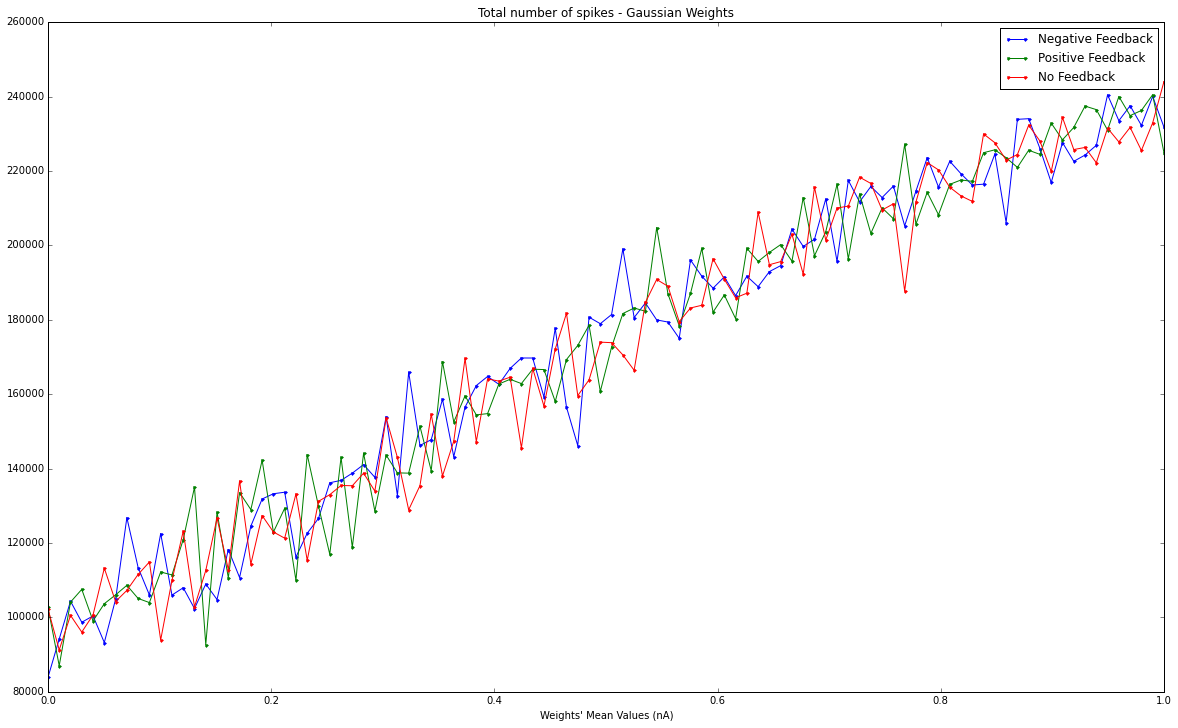

In [17]:
plt.plot(meanvalues,total_spikes_nfb_g,'.-', label="Negative Feedback");

plt.plot(meanvalues,total_spikes_pfb_g,'.-', label="Positive Feedback");

plt.plot(meanvalues,total_spikes_nofb_g,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,meanvalues[-1]);
plt.title("Total number of spikes - Gaussian Weights");
plt.xlabel("Weights' Mean Values (nA)");

# ALL-TO-ALL WITH RANDOM WEIGHTS TRYING TO SIMULATE THE SMALL WORLD EFFECT USING A SIN MODULATION

In [18]:
def wasw_gen(meanvalue):
    wasw=abs(numpy.random.normal(loc=0,scale=10,size=(n*n))*1E-9) #guarantees all the weights are positive (excitatory)
    wasw[:int(n*n*0.2)]=-4*wasw[:int(n*n*0.2)] #makes 20% of the weights negative (inhibitory), and 4x stronger
    numpy.random.shuffle(wasw) #shuffles the weights

    #applies a rectified sin wave to create zeros between the weights
    fsin=10
    wasw=(wasw*numpy.sqrt(numpy.sin(numpy.linspace(0,1,n*n)*2*numpy.pi*fsin)**2)).reshape(n,n)
    wasw+=meanvalue*1E-9 #adds the mean value
    return wasw

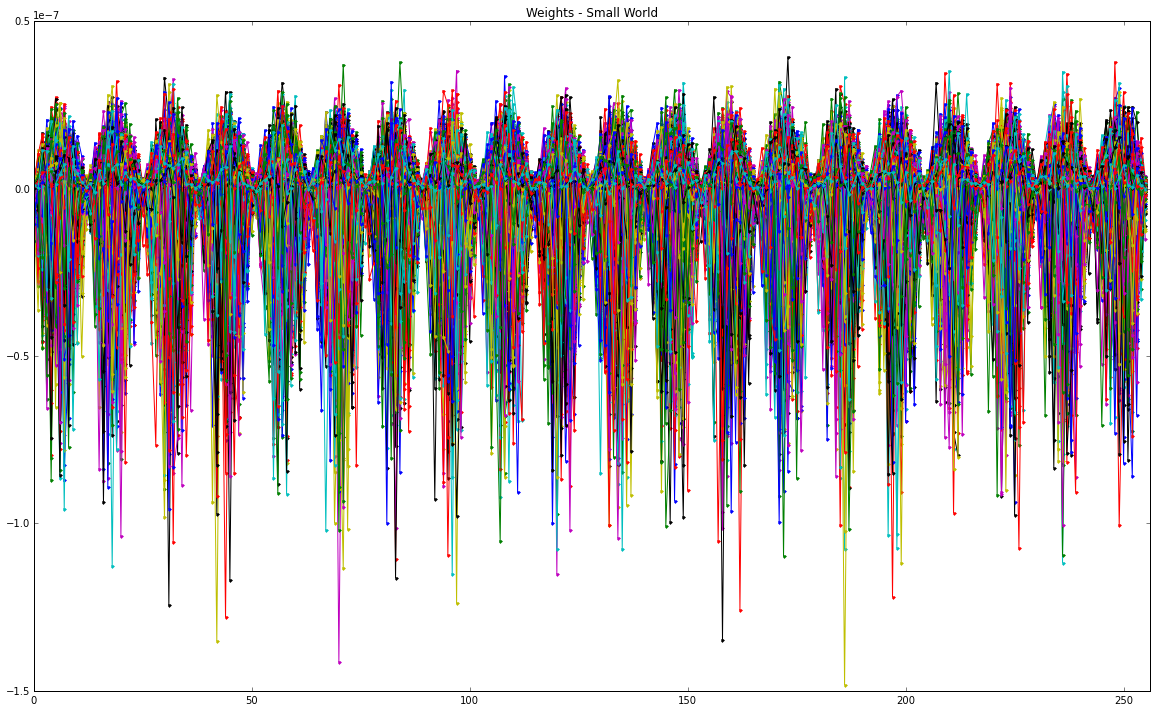

In [19]:
wasw_0=wasw_gen(0)
plt.plot(wasw_0,'.-');
plt.xlim(0,len(wasw_0));
plt.title("Weights - Small World");

In [20]:
total_spikes_nfb_sw=[numpy.array(simulate(nfb,wasw_gen(i))[0]).sum() for i in meanvalues]
total_spikes_pfb_sw=[numpy.array(simulate(pfb,wasw_gen(i))[0]).sum() for i in meanvalues]
total_spikes_nofb_sw=[numpy.array(simulate(nofb,wasw_gen(i))[0]).sum() for i in meanvalues]

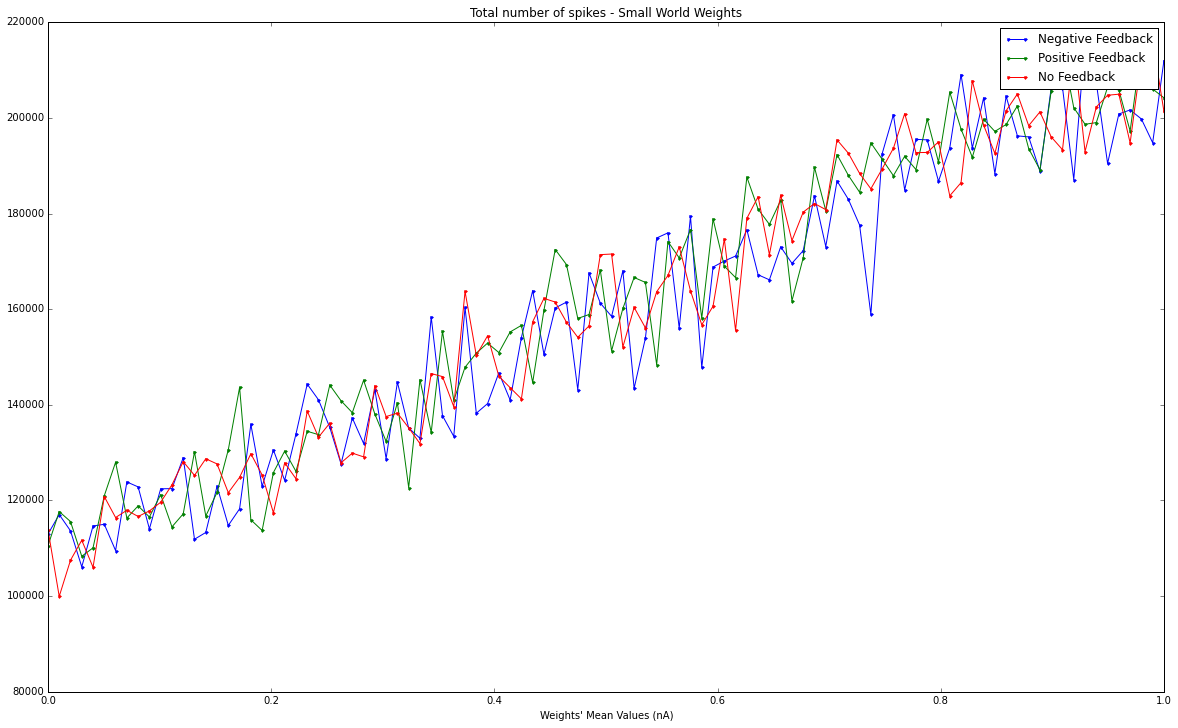

In [21]:
plt.plot(meanvalues,total_spikes_nfb_sw,'.-', label="Negative Feedback");

plt.plot(meanvalues,total_spikes_pfb_sw,'.-', label="Positive Feedback");

plt.plot(meanvalues,total_spikes_nofb_sw,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,meanvalues[-1]);
plt.title("Total number of spikes - Small World Weights");
plt.xlabel("Weights' Mean Values (nA)");

# ALL-TO-ALL WITH WEIGHTS TRYING TO SIMULATE SOME KIND OF LEARNING
### Here I'm considering a system that after a learning phase starts to receive feedback from the output into the input (error signal)

In [22]:
def walearn(meanvalue,learning_increase):
    wa=numpy.random.normal(loc=0,scale=10,size=n*n)*1E-9
    wa[:int(1*(n*n)/10.0)]=learning_increase*abs(wa[:int(1*(n*n)/10.0)]); #increases the value for 1/10 of the weights and makes
                                                                          #them positive.
    wam=wa.mean()
    if wam>0:
        wa-=wam
    else:
        wa+=abs(wam)

    wa+=meanvalue*1E-9
    
    wa_before_shuffle = numpy.array(wa.reshape(n,n))
    numpy.random.shuffle(wa);
    wa=wa.reshape(n,n)
    return wa,wa_before_shuffle


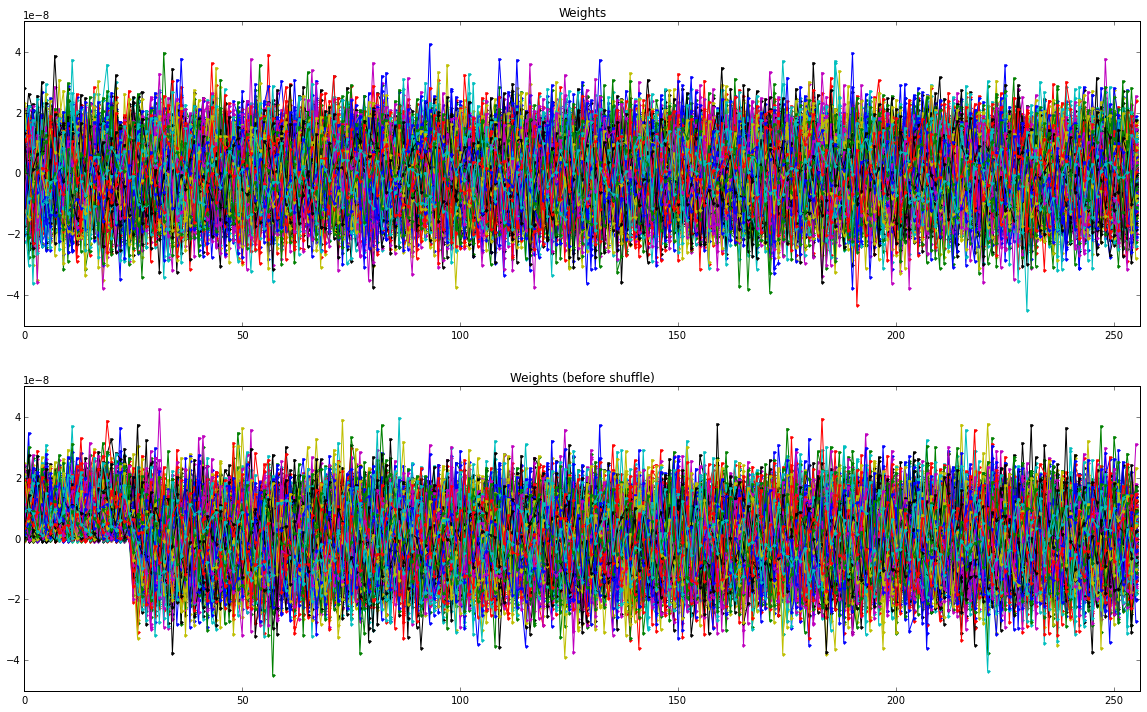

In [23]:
wa_0,wa_before_shuffle_0=walearn(0,1)
plt.subplot(211);
plt.plot(wa_0,'.-');
plt.xlim(0,len(wa_0));
plt.title("Weights");
plt.subplot(212);
plt.plot(wa_before_shuffle_0,'.-');
plt.xlim(0,len(wa_0));
plt.title("Weights (before shuffle)");

In [24]:
total_spikes_nfb_al=[numpy.array(simulate(nfb,walearn(i,1)[0])[0]).sum() for i in meanvalues]
total_spikes_pfb_al=[numpy.array(simulate(pfb,walearn(i,1)[0])[0]).sum() for i in meanvalues]
total_spikes_nofb_al=[numpy.array(simulate(nofb,walearn(i,1)[0])[0]).sum() for i in meanvalues]

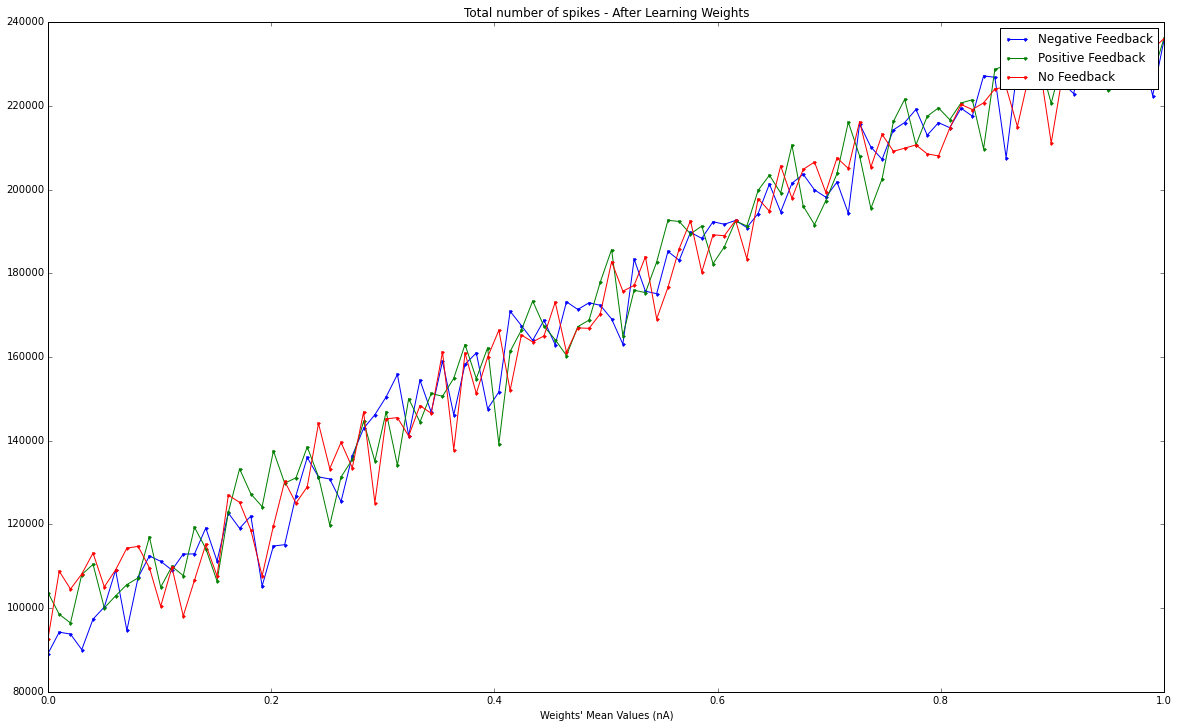

In [25]:
plt.plot(meanvalues,total_spikes_nfb_al,'.-', label="Negative Feedback");

plt.plot(meanvalues,total_spikes_pfb_al,'.-', label="Positive Feedback");

plt.plot(meanvalues,total_spikes_nofb_al,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,meanvalues[-1]);
plt.title("Total number of spikes - After Learning Weights");
plt.xlabel("Weights' Mean Values (nA)");

# Apparently the weights' mean value is the stronger factor in those feedback neural systems. 

# Now I'm going to keep the mean value of the weights equals to zero and change the gain K.

In [26]:
Kvalues = numpy.linspace(0,500,100)

In [27]:
total_spikes_nfb_g_K=[numpy.array(simulate(nfb,numpy.random.normal(loc=0,scale=10,size=(n,n))*1E-9,i)[0]).sum() for i in Kvalues]
total_spikes_pfb_g_K=[numpy.array(simulate(pfb,numpy.random.normal(loc=0,scale=10,size=(n,n))*1E-9,i)[0]).sum() for i in Kvalues]
total_spikes_nofb_g_K=[numpy.array(simulate(nofb,numpy.random.normal(loc=0,scale=10,size=(n,n))*1E-9,i)[0]).sum() for i in Kvalues]

In [28]:
plt.plot(Kvalues,total_spikes_nfb_g_K,'.-', label="Negative Feedback");

plt.plot(Kvalues,total_spikes_pfb_g_K,'.-', label="Positive Feedback");

plt.plot(Kvalues,total_spikes_nofb_g_K,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,Kvalues[-1]);
plt.title("Total number of spikes - Gaussian Weights");
plt.xlabel("Gain K");

In [29]:
total_spikes_nfb_sw_K=[numpy.array(simulate(nfb,wasw_gen(0),i)[0]).sum() for i in Kvalues]
total_spikes_pfb_sw_K=[numpy.array(simulate(pfb,wasw_gen(0),i)[0]).sum() for i in Kvalues]
total_spikes_nofb_sw_K=[numpy.array(simulate(nofb,wasw_gen(0),i)[0]).sum() for i in Kvalues]

In [30]:
plt.plot(Kvalues,total_spikes_nfb_sw_K,'.-', label="Negative Feedback");

plt.plot(Kvalues,total_spikes_pfb_sw_K,'.-', label="Positive Feedback");

plt.plot(Kvalues,total_spikes_nofb_sw_K,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,Kvalues[-1]);
plt.title("Total number of spikes - Small World Weights");
plt.xlabel("Gain K");

In [31]:
total_spikes_nfb_al_K=[numpy.array(simulate(nfb,walearn(0,1)[0],i)[0]).sum() for i in Kvalues]
total_spikes_pfb_al_K=[numpy.array(simulate(pfb,walearn(0,1)[0],i)[0]).sum() for i in Kvalues]
total_spikes_nofb_al_K=[numpy.array(simulate(nofb,walearn(0,1)[0],i)[0]).sum() for i in Kvalues]

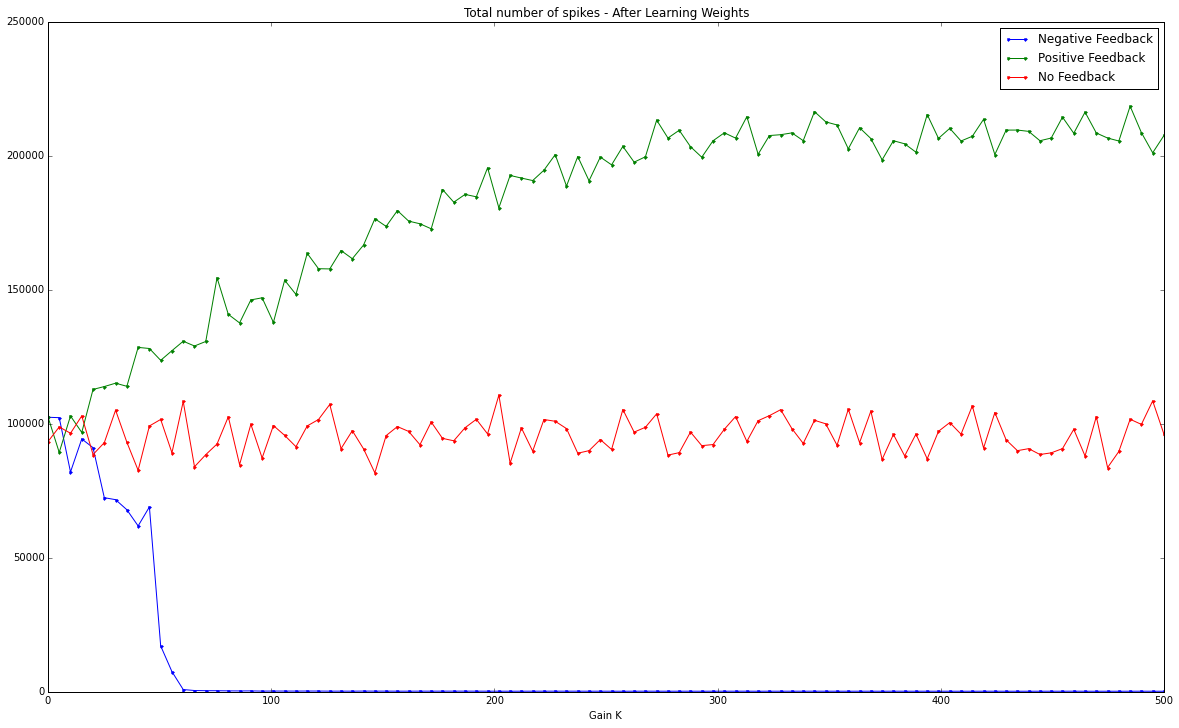

In [32]:
plt.plot(Kvalues,total_spikes_nfb_al_K,'.-', label="Negative Feedback");

plt.plot(Kvalues,total_spikes_pfb_al_K,'.-', label="Positive Feedback");

plt.plot(Kvalues,total_spikes_nofb_al_K,'.-', label="No Feedback");

plt.legend()

plt.xlim(0,Kvalues[-1]);
plt.title("Total number of spikes - After Learning Weights");
plt.xlabel("Gain K");

# According to the experiments above, when the mean value of the weights is kept zero, the system behaves as expected from a SISO according to the type of feedback.

# However, normally after a traditional learning session, the mean value of the weights is different from zero.

# This last series of figures shows how it looks like when the system goes to total saturation (mean value >> 1)

## Negative feedback

In [33]:
wasat=numpy.random.normal(loc=100,scale=10,size=(n,n))*1E-9
nfbs_outputs_s,nfbs_outputs_v,nfbs_outputs_i = simulate(nfb, wasat, K=1)
print "Total Number of Spikes: %d" % numpy.array(nfbs_outputs_s).sum()

Total Number of Spikes: 255796


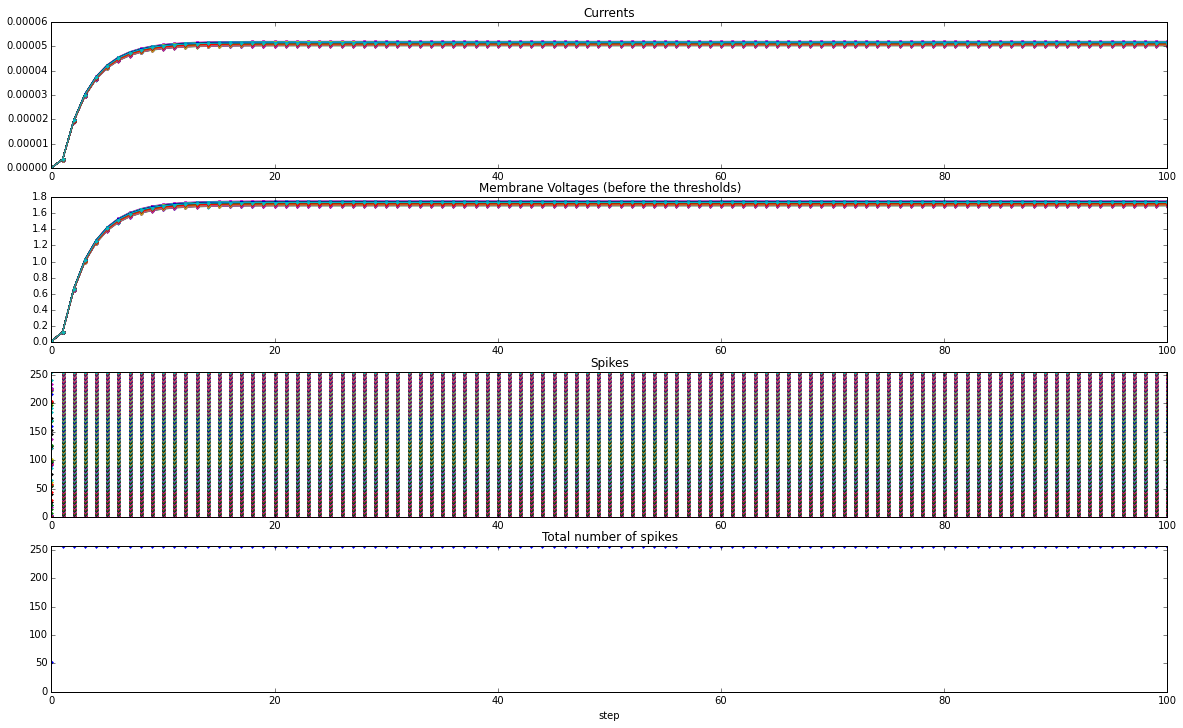

In [34]:
maxt=100
plt.subplot(411)
plt.plot(nfbs_outputs_i,'.-');
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(nfbs_outputs_v,'.-');
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(nfbs_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(nfbs_outputs_s),axis=1),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");


## Positive Feedback

In [35]:
pfbs_outputs_s,pfbs_outputs_v,pfbs_outputs_i = simulate(pfb, wasat, K=1)
print "Total Number of Spikes: %d" % numpy.array(pfbs_outputs_s).sum()

Total Number of Spikes: 255796


In [36]:
maxt=100

plt.subplot(411)
plt.plot(pfbs_outputs_i,'.-');
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(pfbs_outputs_v,'.-');
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(pfbs_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(pfbs_outputs_s),axis=1),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");

## No feedback

In [37]:
nofbs_outputs_s,nofbs_outputs_v,nofbs_outputs_i = simulate(nofb, wasat, K=1)
print "Total Number of Spikes: %d" % numpy.array(nofbs_outputs_s).sum()

Total Number of Spikes: 255796


In [38]:
maxt=100

plt.subplot(411)
plt.plot(nofbs_outputs_i,'.-');
plt.xlim(0,maxt);
plt.title("Currents");

plt.subplot(412)
plt.plot(nofbs_outputs_v,'.-');
plt.xlim(0,maxt);
plt.title("Membrane Voltages (before the thresholds)");

plt.subplot(413)
plt.plot((numpy.array(nofbs_outputs_s)*(numpy.arange(n))),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Spikes");

plt.subplot(414)
plt.plot(numpy.sum(numpy.array(nofbs_outputs_s),axis=1),'.');
plt.xlim(0,maxt);
plt.ylim(-0.1,n+.1);
plt.title("Total number of spikes");
plt.xlabel("step");